In [126]:
# Marketting Campaign (Assignment-2-b)
# Soumen-Dey: Dec-2024
# Lic: Freeware
# Assignment: No-2
# -------------------------------

import pandas as pd
from io import StringIO

import json
from io import FileIO
from json import loads, dumps

from datetime import datetime
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive

from google.colab import drive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# import csv
from os import system, name
from decimal import Decimal, InvalidOperation
from time import sleep
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

import calendar

%matplotlib inline
# ---------------- CODE ----------------------------------------

# Authenticate and create the PyDrive client.
# This part is crucial for accessing files in your Google Drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fName= 'marketing_data.csv'
folderId = '1ScbRfKIR5wy1DsmmTg7wE04sKNWhhni3'

# pd.options.mode.copy_on_write = True

grpSorted = pd.DataFrame()

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


def read_file( id_file ) :
      # file_list = drive.ListFile({'q': "title='MyAiFile.txt' and trashed=false"}).GetList()
      title = "title='" + id_file + "' and trashed=false"
      print ('File reading: ', title)

      # #Get the file from the list as per API Spec
      file_list = drive.ListFile({'q': title}).GetList()

      if len(file_list) > 0:
          file = file_list[0]
          file_content = file.GetContentString()

          return file_content
      else:
        print("File : ", id_file , " not found")


# Conduct Missing values "**** Simple - IMPUTATION *****"
def simple_impute_income(df):
    from sklearn.impute import KNNImputer
    from sklearn.impute import SimpleImputer
    from numpy import nan
    import numpy as np

    numeric_cols = ['Income','Education','Marital_Status']
    non_numeric_cols = ['ID']
    df['Income'] = df[' Income '].str.replace('$', '').str.replace(',', '').astype(float)

    unique_edu = df['Education'].unique()
    unique_marital = df['Marital_Status'].unique()

    print(unique_edu)
    print(unique_marital)
    print('OTHER------------')

    # https://www.statology.org/pandas-create-new-column-based-on-multiple-condition-if-else/
    #define conditions
    # ['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
    eduToNoConditions = [
        (df['Education'] == 'Basic'),
        (df['Education'] == '2n Cycle'),
        (df['Education'] == 'Master'),
        (df['Education'] == 'Graduation'),
        (df['Education'] == 'PhD')
    ]

    # ['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
    maritalConditions = [
        (df['Marital_Status'] == 'Divorced'),
        (df['Marital_Status'] == 'Single'),
        (df['Marital_Status'] == 'Married'),
        (df['Marital_Status'] == 'Together'),
        (df['Marital_Status'] == 'Widow'),
        (df['Marital_Status'] == 'YOLO'),
        (df['Marital_Status'] == 'Alone'),
        (df['Marital_Status'] == 'Absurd')
    ]

    # noToEduConditions = [
    #     (df['Education'] == 99),
    #     (df['Education'] == 199),
    #     (df['Education'] == 299),
    #     (df['Education'] == 399),
    #     (df['Education'] == 499)
    # ]

    #define results
    education_To_no = [99,199,299,399,499]
    no_To_Education = ['Basic','2n Cycle','Master','Graduation','PhD']

    maritalStat_To_no  = [1,2,3,4,5,6,7,8]
    maritalStat_To_Str = ['Divorced', 'Single', 'Married', 'Together', 'Widow', 'YOLO','Alone', 'Absurd']

    #create new column based on conditions in column1 and column2
    df['Education'] = np.select(eduToNoConditions, education_To_no)
    df['Marital_Status'] = np.select(maritalConditions, maritalStat_To_no)
    #view updated DataFrame
    # print(df['Marital_Status'].head(10))

    # perform simple-imputation based on mean
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df_income_imputed = pd.DataFrame(imp_mean.fit_transform(df[numeric_cols]), columns=numeric_cols)

    # reMap the Str Education
    df_income_imputed['Education']      = np.select(eduToNoConditions, no_To_Education)
    df_income_imputed['Marital_Status'] = np.select(maritalConditions, maritalStat_To_Str)

    # print("imputed remap")
    # print(df_income_imputed['Marital_Status'].head(10))

    df_imputed = pd.concat([df[non_numeric_cols].reset_index(drop=True), df_income_imputed], axis=1)
    # (df_imputed).head(300)


    return df_imputed


# Conduct Missing values "**** KNN - IMPUTATION *****"
def knn_impute_income(df):
    from sklearn.impute import KNNImputer
    from sklearn.impute import SimpleImputer
    from numpy import nan
    import numpy as np

    numeric_cols = ['Income','Recency']
    non_numeric_cols = ['ID','Education','Marital_Status']
    df['Income'] = df[' Income '].str.replace('$', '').str.replace(',', '').astype(float)

    unique_edu = df['Education'].unique()
    unique_marital = df['Marital_Status'].unique()

    print(unique_edu)
    print(unique_marital)


    k = 5
    imputer = KNNImputer(n_neighbors=k)
    df_income_imputed = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)
    (df_income_imputed).head(300)

    df_imputed = pd.concat([df[non_numeric_cols].reset_index(drop=True), df_income_imputed], axis=1)

    return df_imputed

def get_TotalExpenditure(df):

    # df['MntWines'] = df['MntWines'].astype(float)
    # df['TotalExpenditure'] = df[['MntWines']].sum(axis=1)
    df['TotalExpenditure'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
    df['NoOfChildren'] = df['Kidhome'] + df['Teenhome']
    df['Age'] = 2025 - df['Year_Birth']
    # print(df.columns)

    df = pd.DataFrame(df, columns=['ID', 'Age', 'NoOfChildren','TotalExpenditure']).sort_values(by='ID', ascending=True);

    return df

# print table
def display_tabular(content):

  jsonData = json.loads(content)
  grpTable = tabulate(jsonData, headers="keys", tablefmt="grid")

  return grpTable

def dfToJson(df_local):
      result = df_local.to_json(orient="records")
      parsed = loads(result)
      strJson = dumps(parsed)

      return strJson

def PurchasesPerChannel(df):
    # df['Total-WebPurchases'] = df['NumWebPurchases'] * df['MntWines']
    # df['Total-CatalogPurchases'] = df['NumCatalogPurchases'] * df['MntFruits']
    # df['Total-StorePurchases'] = df['NumStorePurchases'] * df['MntMeatProducts']

    df['Total_WebPurchases'] = df['NumWebPurchases']
    df['Total_CatalogPurchases'] = df['NumCatalogPurchases']
    df['Total_StorePurchases'] = df['NumStorePurchases']

    df['Total_Purchases(3-cnnl)'] = df['Total_WebPurchases'] + df['Total_CatalogPurchases'] + df['Total_StorePurchases']

    df = pd.DataFrame(
        df,
        columns=['ID', 'Age', 'Total_WebPurchases', 'Total_CatalogPurchases', 'Total_StorePurchases', 'Total_Purchases(3-cnnl)']).sort_values(by='ID', ascending=True);

    # df['ID'] = df['ID'].astype(int)

    return df

def PurchasesByAgeCategory(df):
    df = pd.DataFrame(df, columns=['Age', 'Total_WebPurchases', 'Total_StorePurchases']).sort_values(by='Age', ascending=False);
    # df["AgeCategory"] = pd.cut(df["Age"], bins=[10, 20, 30, 40, 50, 60, 70], labels=['10-20', '20-30', '30-40', '40-50', '50-60', '60-70'])
    # df["AgeCategory"] = pd.cut(df["Age"], bins=[15, 60, 80, 150], labels=['(15-60)', '(60-80)', '(80-150)'])
    df["AgeCategory"] = pd.cut(df["Age"], bins=[15, 60, 80, 150], labels=['General', 'Above-60', 'Eldery'])

    df = df.groupby('AgeCategory').sum()

    df = df.drop(columns=['Age'])
    df = df.reset_index()
    return df

# ---- Code starts -------------
records = read_file(fName)
dataset = pd.read_csv(StringIO(records))
# ---------------------------------------------------------
df_original = pd.DataFrame(dataset)


File reading:  title='marketing_data.csv' and trashed=false


In [127]:
# @title Apply simple_impute to identify missing Values in Income
# ----------------- Part 1 -------------------------------------------------------
# Apply simple_impute to identify missing Values in Income
# ----------------------------------------------------------------------------------
df_1 = simple_impute_income(df_original)
# ----------- SUM -----------
# print(color.BOLD + 'Hello, World!' + color.END)
print (color.BOLD + "\n\n◙ Purchase Analysis [Purchase for his/her children by person] in Last 2 yrs" + color.END)
print ("◙ Taking only 10 records to display for Table\n")
recToDisplay = 10
df_2 = get_TotalExpenditure(df_original)
table = display_tabular(dfToJson(df_2.head(recToDisplay)))
print (table)

# --------------- Purchases Per Channel --------------------------------------------------------
#  Derive the total purchases from the number of transactions across the three channels.
# ----------------------------------------------------------------------------------------------
print ("\n\n◙ Purchase Analysis Per Channel : in Last 2 yrs")
print ("◙ Taking only 10 records to display for Table\n")

df = PurchasesPerChannel(df_original)
table = display_tabular(dfToJson(df.head(recToDisplay)))
print (table)

# Create the box plot using Plotly Express
print ("\nBox Plot :(Entire Dataset)")
print ("if Not printing, please try in google colab. - This is an interactive plot, so please hover")

# Generate box plots and histograms to gain insights into the distributions and identify outliers. Implement outlier treatment as needed.
import plotly.express as px
fig = px.box(df, y="Total_Purchases(3-cnnl)", title="Channel wise purchase")
fig.update_layout(height=600, width=700)
fig.show()

# sns.boxplot(data=df, y="Total_Purchases(3-cnnl)", color=".8", linecolor="#137", linewidth=.75)
# plt.show()

# box = sns.boxplot(data=df, y="Total_Purchases(3-cnnl)")
# plt.show()


['Graduation' 'PhD' '2n Cycle' 'Master' 'Basic']
['Divorced' 'Single' 'Married' 'Together' 'Widow' 'YOLO' 'Alone' 'Absurd']
OTHER------------


◙ Purchase Analysis [Purchase for his/her children by person] in Last 2 yrs
◙ Taking only 10 records to display for Table

+------+-------+----------------+--------------------+
|   ID |   Age |   NoOfChildren |   TotalExpenditure |
+======+=======+================+====================+
|    0 |    40 |              0 |               1198 |
+------+-------+----------------+--------------------+
|    1 |    64 |              0 |                577 |
+------+-------+----------------+--------------------+
|    9 |    50 |              2 |                120 |
+------+-------+----------------+--------------------+
|   13 |    78 |              1 |                 32 |
+------+-------+----------------+--------------------+
|   17 |    54 |              1 |               1028 |
+------+-------+----------------+--------------------+
|   20 |    60 |  


Histogram :(Entire Dataset)



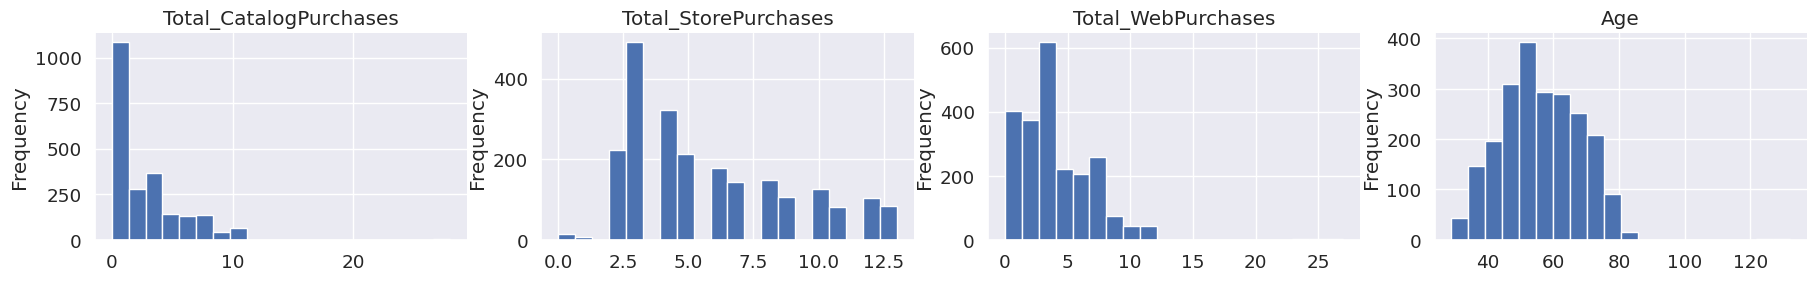

In [128]:

print ("\nHistogram :(Entire Dataset)\n")

from matplotlib import pyplot as plt
plt.subplots_adjust(bottom=0.05, right=2.8, top=1.0)

plt.subplot(2, 4, 1)
# Creating 6 subplots and unpacking the output array immediately
df['Total_CatalogPurchases'].plot(kind='hist', bins=20, title='Total_CatalogPurchases')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(2, 4, 2)
df['Total_StorePurchases'].plot(kind='hist', bins=20, title='Total_StorePurchases')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(2, 4, 3)
df['Total_WebPurchases'].plot(kind='hist', bins=20, title='Total_WebPurchases')
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplot(2, 4, 4)
df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)




Purchase Trends by Old-Age : in Last 2 yrs

+---------------+----------------------+------------------------+
| AgeCategory   |   Total_WebPurchases |   Total_StorePurchases |
+===============+======================+========================+
| General       |                 5610 |                   7949 |
+---------------+----------------------+------------------------+
| Above-60      |                 3440 |                   4884 |
+---------------+----------------------+------------------------+
| Eldery        |                  100 |                    137 |
+---------------+----------------------+------------------------+


<ipython-input-126-639988dc7582>:240: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



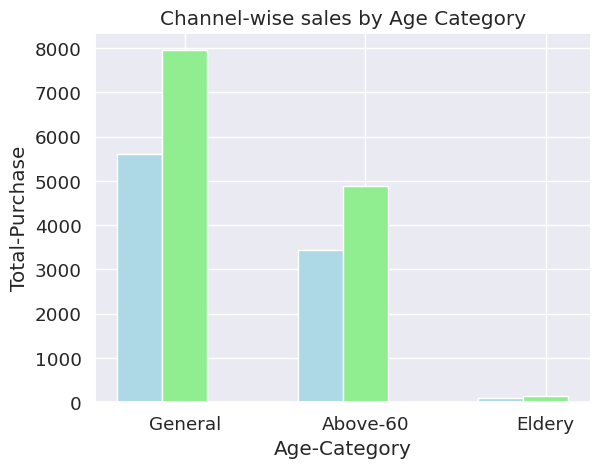


Hypotheses Analysis:
--------------------
Eldery people    : True: Older individuals may not possess the same level of technological proficiency and may, therefore, lean toward traditional in-store shopping preferences.
Mid age people   : on an average a moderate both Online and Offline purchasers.
Young age people : are more on online as compared to store visit.


In [129]:
#  @title Purchase trends by Old Age
# -------------------------- Purchase trends by Old Age --------------
print ("\n\nPurchase Trends by Old-Age : in Last 2 yrs\n")
df = PurchasesByAgeCategory(df_original)
table = display_tabular(dfToJson(df.head(10)))
print (table)

# Print bar chart
import numpy as np
barWidth = 0.25

r1 = np.arange(len(df['AgeCategory']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, df['Total_WebPurchases'], color='LightBlue', width=barWidth, edgecolor='white', label='Total_WebPurchases')
plt.bar(r2, df['Total_StorePurchases'], color='LightGreen', width=barWidth, edgecolor='white', label='Total_StorePurchases')

plt.xlabel('Age-Category')
plt.ylabel('Total-Purchase')
plt.title('Channel-wise sales by Age Category')
plt.xticks([r + barWidth for r in range(len(df['AgeCategory']))], df['AgeCategory'])
plt.show()

# Test the following hypotheses:
print("\nHypotheses Analysis:")
print("--------------------")
print ("Eldery people    : True: Older individuals may not possess the same level of technological proficiency and may, therefore, lean toward traditional in-store shopping preferences.")
print ("Mid age people   : on an average a moderate both Online and Offline purchasers.")
print ("Young age people : are more on online as compared to store visit.")






Channel wise trends: Customers having children
+----------------+------------------------+-----------------------+
|   NoOfChildren |   Total_OnLinePurchase |   Total_StorePurchase |
+================+========================+=======================+
|              1 |                   7138 |                  6282 |
+----------------+------------------------+-----------------------+
|              2 |                   1824 |                  1793 |
+----------------+------------------------+-----------------------+
|              3 |                    208 |                   198 |
+----------------+------------------------+-----------------------+





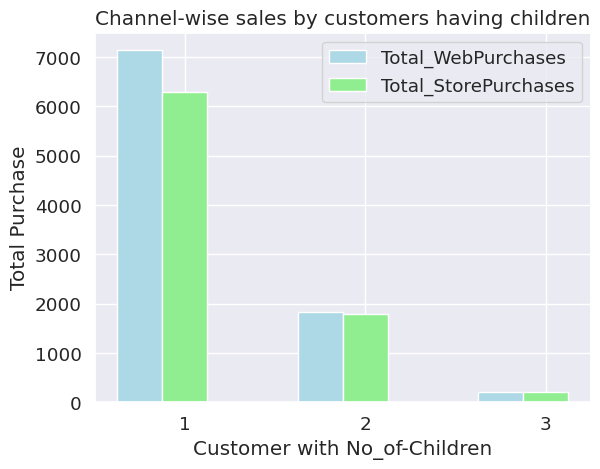


Hypotheses Analysis:---------------
Customer having more children: (FALSE): Customers with children likely experience time constraints, making online shopping a more convenient option.
Customer having single child  - preferring doing big purchase having OnLine as most preferred.

***Final Comment:

	No major diff found in terms of OnLine vs Store purchase trends - when customers having children.
	Physical stores DOES NOT face the risk of cannibalization by alternative distribution channels.


In [ ]:

# @title Channel wise purchase trends: Customers having children at home
def GetChannelTrendsHavingChildren(df):

    df['Total_WebPurchases']     = df['NumWebPurchases']
    df['Total_CatalogPurchases'] = df['NumCatalogPurchases']
    df['Total_StorePurchases']   = df['NumStorePurchases']

    df['Total_OnLinePurchase'] =  df['Total_WebPurchases'] + df['Total_CatalogPurchases']
    df['Total_StorePurchase']  =  df['Total_StorePurchases']
    df['NoOfChildren']         =  df['Kidhome'] + df['Teenhome']

    df = pd.DataFrame(df, columns=['Age', 'NoOfChildren', 'Total_OnLinePurchase', 'Total_StorePurchase']);

    df = df[(df != 0).all(1)] #dropping if no children

    df = df.groupby('NoOfChildren').sum()
    df = df.drop(columns=['Age']) # no need to display age

    return df.sort_values(by='NoOfChildren', ascending=True).reset_index();


# ---- Find Customer - OnlineShopping - OffLineShopping - NoOfChildren : Trends --------------
print ("Channel wise trends: Customers having children")
df = GetChannelTrendsHavingChildren(df_original)

# df = df.groupby('NoOfChildren').sum()

# df = df.drop(columns=['Age'])
# df = df.reset_index()
table = display_tabular(dfToJson(df))
print (table)

# Print bar chart
print("\n\n")
import numpy as np
barWidth = 0.25

r1 = np.arange(len(df['NoOfChildren']))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

plt.bar(r1, df['Total_OnLinePurchase'], color='LightBlue', width=barWidth, edgecolor='white', label='Total_WebPurchases')
plt.bar(r2, df['Total_StorePurchase'], color='LightGreen', width=barWidth, edgecolor='white', label='Total_StorePurchases')

plt.xlabel('Customer with No_of-Children')
plt.ylabel('Total Purchase')
plt.title('Channel-wise sales by customers having children')
plt.xticks([r + barWidth for r in range(len(df['NoOfChildren']))], df['NoOfChildren'])
plt.legend()
plt.show()

print("\nHypotheses Analysis:---------------")
print("Customer having more children: (FALSE): Customers with children likely experience time constraints, making online shopping a more convenient option.")
print("Customer having single child  - preferring doing big purchase having OnLine as most preferred.")
print("\n***Final Comment:")
print("\n\tNo major diff found in terms of OnLine vs Store purchase trends - when customers having children.")
print("\tPhysical stores DOES NOT face the risk of cannibalization by alternative distribution channels.")



Does the United States significantly outperform the rest of the world in total purchase volumes?


+-----------+--------------------+
| Country   |   TotalExpenditure |
+===========+====================+
| SP        |             662220 |
+-----------+--------------------+
| SA        |             211071 |
+-----------+--------------------+
| CA        |             168532 |
+-----------+--------------------+
| AUS       |              89763 |
+-----------+--------------------+
| IND       |              79485 |
+-----------+--------------------+
| GER       |              74913 |
+-----------+--------------------+
| US        |              67882 |
+-----------+--------------------+
| ME        |               3122 |
+-----------+--------------------+

US(United States) Rank in global sales : 7 th lowest out of : 8


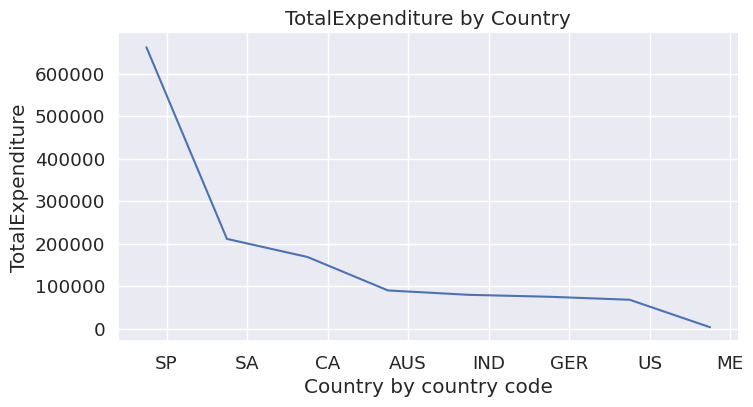


Hypotheses Analysis:-
Does the United States significantly outperform the rest of the world in total purchase volumes? : False


In [ ]:
#  @title Check if USA have higher sales rate
#------------------------------------------------------------------------------------------------
# -----(7.d)----- Check if USA have higher sales rate
#------------------------------------------------------------------------------------------------
def GetHighestSalesCountry(df):
    df = pd.DataFrame(df, columns=['Country', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']).sort_values(by='Country', ascending=True);
    df['TotalExpenditure'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
    df = df.groupby('Country').sum()
    df = df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'])
    df = df.sort_values(by='TotalExpenditure', ascending=False).reset_index()

    return df

print ("\nDoes the United States significantly outperform the rest of the world in total purchase volumes?")
df = GetHighestSalesCountry(df_original)

print("\n")
table = display_tabular(dfToJson(df))
print (table)

usPosition = df.loc[df['Country'] == 'US']
usPositionInGlobalMarket = (usPosition.index[0]) + 1
print("\nUS(United States) Rank in global sales :", usPositionInGlobalMarket, "th lowest out of :", len(df))

from matplotlib import pyplot as plt
df['TotalExpenditure'].plot(kind='line', figsize=(8, 4), title='TotalExpenditure by Country')
plt.xlabel('Country by country code')
plt.ylabel('TotalExpenditure')
plt.xticks([r + barWidth for r in range(len(df['Country']))], df['Country'])
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

print("\nHypotheses Analysis:-")
isUSAaHighestSalesCountry = (usPosition.index[0] == 0)
print("Does the United States significantly outperform the rest of the world in total purchase volumes? :", isUSAaHighestSalesCountry )




Top and Low performing products with the revenue.
+---------+-----------+--------------+------------------------+
|   index | Product   |   TotalSales | Remark                 |
+=========+===========+==============+========================+
|       0 | Wine      |       680816 | Highest Saling Product |
+---------+-----------+--------------+------------------------+
|       2 | Meat      |       373968 |                        |
+---------+-----------+--------------+------------------------+
|       5 | Gold      |        98609 |                        |
+---------+-----------+--------------+------------------------+
|       3 | Fish      |        84057 |                        |
+---------+-----------+--------------+------------------------+
|       4 | Sweet     |        60621 |                        |
+---------+-----------+--------------+------------------------+
|       1 | Fruit     |        58917 | Lowest Saling Product  |
+---------+-----------+--------------+---------------

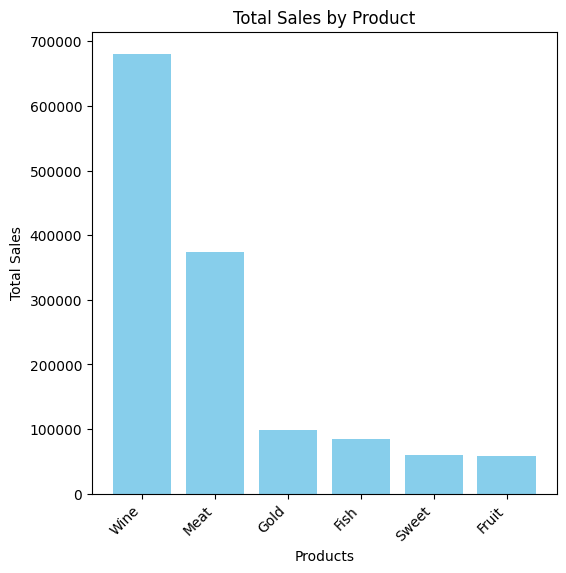

In [ ]:
# @title Identify the top-performing products and those with the lowest revenue
#------------------------------------------------------------------------------------------------
#     (8.a) Identify the top-performing products and those with the lowest revenue.
#------------------------------------------------------------------------------------------------
def GroupByProducts(df):
    df = pd.DataFrame(df, columns=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']).sort_values(by='MntWines', ascending=False);
    df['TotalExpenditure'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

    totalWineSales  = df['MntWines'].sum()
    totalFruitSales = df['MntFruits'].sum()
    totalMeatSales  = df['MntMeatProducts'].sum()
    totalFishSales  = df['MntFishProducts'].sum()
    totalSweetSales = df['MntSweetProducts'].sum()
    totalGoldSales  = df['MntGoldProds'].sum()

    df = pd.DataFrame(
                        {
                          'Product'    : ['Wine','Fruit', 'Meat', 'Fish','Sweet', 'Gold'],
                          'TotalSales' : [totalWineSales, totalFruitSales, totalMeatSales, totalFishSales, totalSweetSales, totalGoldSales],
                          'Remark' : None
                        }
                     ).sort_values(by=['TotalSales'], ascending=False).reset_index();

    highestSalingProduct = df.loc[0]['Product']
    lowestSalingProduct  = df.loc[len(df)-1]['Product']

    df.loc[df['Product'] == highestSalingProduct, 'Remark'] = 'Highest Saling Product'
    df.loc[df['Product'] == lowestSalingProduct, 'Remark']  = 'Lowest Saling Product'

    return df


print("\nTop and Low performing products with the revenue.")
df = GroupByProducts(df_original)

# ---- Print Tables -----------------------------------------------------
table = display_tabular(dfToJson(df))
print (table)

# -- Show Plots ---------------------------------------------------------
import matplotlib.pyplot as plt

# # Sample Data (Replace with your dataframe 'df')
# products = ['Wine', 'Fruit', 'Meat', 'Fish', 'Sweet', 'Gold']
# total_sales = [680816, 58917, 373968, 129161,  92095, 100658]

plt.figure(figsize=(6, 6))
plt.bar(df.Product, df.TotalSales, color='skyblue')
plt.xlabel('Products')
plt.ylabel('Total Sales')
plt.title('Total Sales by Product')
_ = plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()




Examine if there is a correlation between customers' age and the acceptance rate of the last campaign.
+----------------+-------------+
|   AcceptedCmp5 |         Age |
+================+=============+
|     1          | -0.00712254 |
+----------------+-------------+
|    -0.00712254 |  1          |
+----------------+-------------+


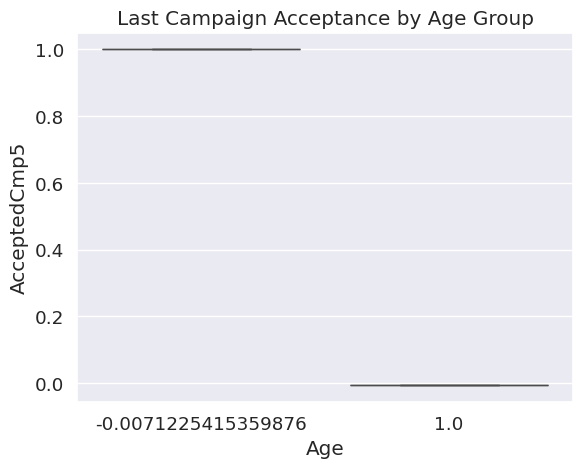


Analysis: Not sure about the data and plots, still need to double check for correctness.


In [ ]:
#---------------------------------------------------------------------------------------------------------------------------
#     (8.b) Examine if there is a correlation between customers' age and the acceptance rate of the last campaign.
#---------------------------------------------------------------------------------------------------------------------------
print("\nExamine if there is a correlation between customers' age and the acceptance rate of the last campaign.")
def CustomerAgeByLastCampaign(df):
    df = pd.DataFrame(df, columns=['Year_Birth', 'AcceptedCmp5']);
    df['Age'] = 2024 - df['Year_Birth']
    df.drop(columns=['Year_Birth'], inplace=True)

    # filter1 = df["AcceptedCmp5"] != 0;
    # df = df.where(filter1);
    # df = df.dropna().reset_index(drop=True)

    # df = df.groupby('Age').mean()
    # df = df.sort_values(by='Age', ascending=True)

    df = df.corr(method='pearson')
    return df


df = pd.DataFrame(df_original);
df = CustomerAgeByLastCampaign(df)
table = display_tabular(dfToJson(df))
print (table)


# @title Last Campaign Acceptance by Age Group

import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='Age', y='AcceptedCmp5', data=df)
plt.xlabel('Age')
plt.ylabel('AcceptedCmp5')
_ = plt.title('Last Campaign Acceptance by Age Group')
plt.show()

print("\nAnalysis: Not sure about the data and plots, still need to double check for correctness.")

# ---- Print Tables -----------------------------------------------------
# table = display_tabular(dfToJson(df))
# print (table)

# df['Age'] = 2025 - df['Year_Birth']
# df = pd.DataFrame(df_original, columns=['Age', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2']).sort_values(by='Age', ascending=False);




 C. Determine the country with the highest number of customers who accepted the last campaign.
+-----------+----------------+
| Country   |   AcceptedCmp5 |
+===========+================+
| SP        |             89 |
+-----------+----------------+
| CA        |             21 |
+-----------+----------------+
| SA        |             21 |
+-----------+----------------+
| AUS       |             13 |
+-----------+----------------+
| GER       |              8 |
+-----------+----------------+
| IND       |              6 |
+-----------+----------------+
| US        |              5 |
+-----------+----------------+
| ME        |              0 |
+-----------+----------------+


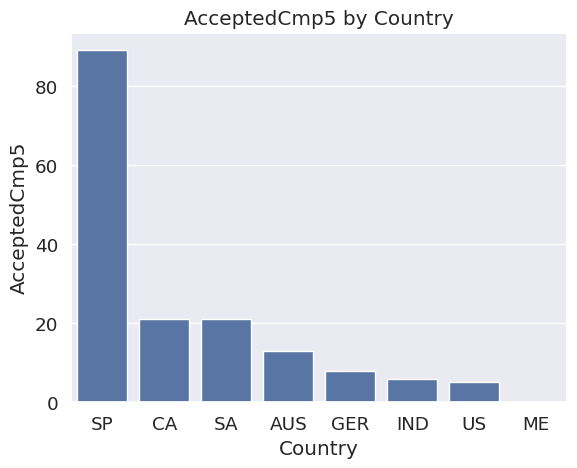

In [ ]:
# @title Determine the country with the highest number of customers who accepted the last campaign
#-------------------------------------------------------------------------------------------------
# (8.c) Determine the country with the highest number of customers who accepted the last campaign.
#-------------------------------------------------------------------------------------------------

print ("\n C. Determine the country with the highest number of customers who accepted the last campaign.")

def GetCountryWirthHightestNoOfCustomers(df):
    df = pd.DataFrame(df, columns=['Country', 'AcceptedCmp5']).sort_values(by='Country', ascending=True);
    df = df.groupby('Country').sum()
    df = df.sort_values(by='AcceptedCmp5', ascending=False).reset_index()

    return df

df = GetCountryWirthHightestNoOfCustomers(df_original)

table = display_tabular(dfToJson(df))
print (table)

# print plot
import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar chart using seaborn
sns.barplot(x='Country', y='AcceptedCmp5', data=df)

# Add labels and title (optional)
plt.xlabel("Country")
plt.ylabel("AcceptedCmp5")
plt.title("AcceptedCmp5 by Country")

# Display the chart
plt.show()



Investigate if there is a discernible pattern in the number of children at home and the total expenditure.
+----------------+--------------------+
|   NoOfChildren |   TotalExpenditure |
+================+====================+
|              0 |             705647 |
+----------------+--------------------+
|              1 |             533243 |
+----------------+--------------------+
|              2 |             103544 |
+----------------+--------------------+
|              3 |              14554 |
+----------------+--------------------+

The higher the customers have children, the lower has its total expenditure


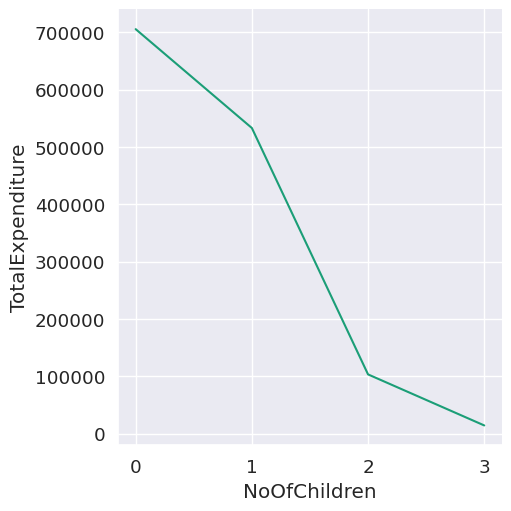

In [ ]:
#------------------------------------------------------------------------------------------------------------------
#  (8.d) Investigate if there is a discernible pattern in the number of children at home and the total expenditure.
#------------------------------------------------------------------------------------------------------------------
print ("\nInvestigate if there is a discernible pattern in the number of children at home and the total expenditure.")

def TotalExpenditureByChildrenAtHome(df):
    df = pd.DataFrame(df, columns=['NoOfChildren', 'TotalExpenditure']);
    df = df.groupby('NoOfChildren').sum()
    df = df.sort_values(by='TotalExpenditure', ascending=False).reset_index()

    return df

df = TotalExpenditureByChildrenAtHome(df_original)
table = display_tabular(dfToJson(df))
print (table)

# --------- Identify if customer with more children has lesser buy---------
flag = True;
for i in range (0, len(df)-1):
  if (df.iloc[i]["NoOfChildren"] > df.iloc[i+1]["NoOfChildren"]):
    flag = False

if(flag is True):
  print("\nThe higher the customers have children, the lower has its total expenditure")
else:
  print("\nThe higher the customers have children, the higher has its total expenditure")

# @title NoOfChildren vs TotalExpenditure
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['NoOfChildren']
  ys = series['TotalExpenditure']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(5, 5), layout='constrained')
df_sorted = df.sort_values('NoOfChildren', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('NoOfChildren')
_ = plt.ylabel('TotalExpenditure')


+-------------+------------+
|   Education |   Complain |
+=============+============+
|         399 |         14 |
+-------------+------------+
|         199 |          4 |
+-------------+------------+
|         299 |          2 |
+-------------+------------+
|         499 |          1 |
+-------------+------------+
|          99 |          0 |
+-------------+------------+


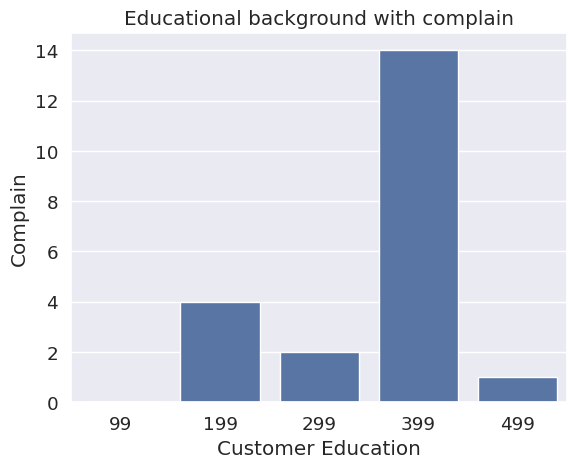

In [ ]:
# @title Educational background of customers who lodged complaints
#------------------------------------------------------------------------------------------------
# --- Analyze the educational background of customers who lodged complaints in the last two years
#------------------------------------------------------------------------------------------------
def ComplaignLodgedByCustomer(df):
    df = pd.DataFrame(df, columns=['Education', 'Complain']).sort_values(by='Education', ascending=True);
    df = df.groupby('Education').sum()

    df = df.sort_values(by='Complain', ascending=False).reset_index()

    return df


df = ComplaignLodgedByCustomer(df_original)
table = display_tabular(dfToJson(df))
print (table)

# @title Educational background with complain

import seaborn as sns
import matplotlib.pyplot as plt

# Create the bar plot using seaborn
sns.barplot(x='Education', y='Complain', data=df)

# Add labels and title
plt.xlabel('Customer Education')
plt.ylabel('Complain')
plt.title('Educational background with complain')

# Display the plot
plt.show()




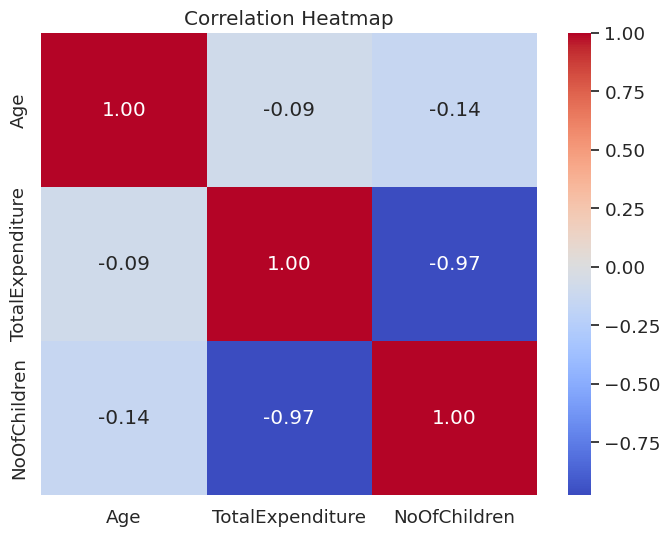

In [136]:
# @title heatmap to illustrate the correlation between different pairs of variables

# Generate a heatmap to illustrate the correlation between different pairs of variables.
# Identify correlation vetween various variables
# -- total number of children, age, and total spending
def CorrBetweenVariables(df):
    df = pd.DataFrame(df, columns=['Age', 'Kidhome', 'Teenhome', 'TotalExpenditure'])
    df['NoOfChildren'] = df['Kidhome'] + df['Teenhome']
    df.drop(columns=['Kidhome', 'Teenhome'], inplace=True)

    df = df.corr(method='pearson')

    return df;

df = CorrBetweenVariables(df_original)

# prompt: Using dataframe df: heatmap
import matplotlib.pyplot as plt
import seaborn as sns

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [147]:
# @title Apply ordinal and one-hot encoding based on the various types of categorical variables
# ------- Apply ordinal and one-hot encoding based on the various types of categorical variables.  -------
#one hot encoding using OneHotEncoder

def Encoding_OneHotEncoder(df):

      # Do complain analysis by Age-group
      data = {
              'Customer_Age_Category': ['20-40','40-80','80-150'],
              'HasAvgComplain': ['Yes','No', 'Yes'],
              'Customer_Type': ['UnSatisfied', 'Satisfied', 'UnSatisfied'],
            }
      # TODO:(smn): The above dataset need to be dynamically prepared from actual df/dataset

      import pandas as pd
      from sklearn.preprocessing import OneHotEncoder

      df = pd.DataFrame(data)

      #Extract categorical columns from the dataframe
      #Here we extract the columns with object datatype as they are the categorical columns
      categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
      encoder = OneHotEncoder(sparse_output=False)

      # Apply one-hot encoding to the categorical columns
      one_hot_encoded = encoder.fit_transform(df[categorical_columns])

      #Create a DataFrame with the one-hot encoded columns
      #We use get_feature_names_out() to get the column names for the encoded data
      one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns))

      # Concatenate the one-hot encoded dataframe with the original dataframe
      df_encoded = pd.concat([df, one_hot_df], axis=1)

      # Drop the original categorical columns
      df_encoded = df_encoded.drop(categorical_columns, axis=1)

      return df_encoded

df = Encoding_OneHotEncoder(df_original)
print(f"Encoded Customer data : \n{df}")

table = display_tabular(dfToJson(df))
print (table)



Encoded Customer data : 
   Customer_Age_Category_20-40  Customer_Age_Category_40-80  \
0                          1.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          0.0   

   Customer_Age_Category_80-150  HasAvgComplain_No  HasAvgComplain_Yes  \
0                           0.0                0.0                 1.0   
1                           0.0                1.0                 0.0   
2                           1.0                0.0                 1.0   

   Customer_Type_Satisfied  Customer_Type_UnSatisfied  
0                      0.0                        1.0  
1                      1.0                        0.0  
2                      0.0                        1.0  
+-------------------------------+-------------------------------+--------------------------------+---------------------+----------------------+---------------------------+-----------------------------+